# How to use NeuralDE's DiffusionEnhancer



## Load pretrained models and attacked images

First we load a diffusion probabilistic model (2) pretrained in the Imagenet dataset. Due to its size, we use Hugging Face's accelerator library to easily manage the use of the available GPUs. To run this notebook, we recommend a 32 GB GPU with cuda toolkit 11 or higher installed. 


In [1]:
import sys
sys.path.append("..")
import time
#%load_ext autoreload
#%autoreload 2

#import numpy as np
#np.random.seed(42)
#import torch
#torch.manual_seed(42)

In [2]:
from neural_de.transformations import DiffusionEnhancer
from neural_de.transformations._diffusion._diffpure_config import DiffPureConfig


start=time.time()
#from accelerate import Accelerator

#accelerator = Accelerator()
#device = accelerator.device
#device = "cpu"
# Load ADVpurifier
config= DiffPureConfig()
config.t = 15
device = "cuda"
purifier = DiffusionEnhancer(device=device, config=config)

2025-03-06 17:34:50.742958: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 17:34:50.758433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741282490.776288    1657 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741282490.781648    1657 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 17:34:50.799431: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[03-06 17:34:53] {/home/jovyan/Maturation/env-testneural_github312/lib/python3.12/site-packages/neural_de/utils/_twe_logger.py:123} INFO - Logger: name: neural_de_logger, handlers: [<StreamHandler stdout (DEBUG)>]
[03-06 17:34:57] {/home/jovyan/Maturation/env-testneural_github312/lib/python3.12/site-packages/neural_de/utils/_minio.py:67} INFO - Model already available locally, skipping download
[03-06 17:34:57] {/home/jovyan/Maturation/env-testneural_github312/lib/python3.12/site-packages/neural_de/transformations/_diffusion/_rev_guided_diffusion.py:31} INFO - Building DiffPure model
[03-06 17:34:57] {/home/jovyan/Maturation/env-testneural_github312/lib/python3.12/site-packages/neural_de/transformations/_diffusion/_rev_guided_diffusion.py:32} DEBUG - Model Diffpure loaded with config : DiffPureConfig(weights_path=PosixPath('/home/jovyan/.neuralde/diffpure/256x256_diffusion_uncond.pt'), img_shape=(3, 256, 256), attention_resolutions=[32, 16, 8], num_classes=None, dims=2, learn_sigma=Tru

&nbsp;

Now we load a pre-trained model of the welding classifier that outputs class 0 for normal and 1 to non compliante weldings respectively. Previously, we have selected randomly a group of 128 images from the test set, and attacked them using the standard version of the autoattack library (3). For convenience the images, and their attacked versions are stored in Pytorch tensors.

As will be noted, the accuracy of the classifier drops from 95.31% in the original images to 0% after the adversarial attack. This evidences the success of the method to trick the classifier making him predict defectuous weldings as conformal, and the opposite.


In [3]:
# Load a pre-trained model
import torch

# Load the classifier pretrained weights
weights_dir = '../neuralde_renault/pretrained_classifier/resnet_renault_epoch_4.pth'
classifier = torch.load(weights_dir,  map_location=torch.device(device))#.to("cpu")

# Load the batch of 128 images and its attacked versions
X_attacked, Y_attacked = torch.load('../neuralde_renault/data/attacked_X.pth').to(device), torch.load('../neuralde_renault/data/attacked_Y.pth').to(device)
X, Y = torch.load('../neuralde_renault/data/X.pth').to(device), torch.load('../neuralde_renault/data/Y.pth').to(device)


FileNotFoundError: [Errno 2] No such file or directory: '../neuralde_renault/pretrained_classifier/resnet_renault_epoch_4.pth'

In [ ]:
from autoattack import AutoAttack

# Create instance of standard attacks
attack = AutoAttack(classifier.eval(), device=device)

# Caculate the accuracy of the model in the clean and attacked images
original_acc = attack.clean_accuracy(X, Y)
attacked_acc = attack.clean_accuracy(X_attacked, Y_attacked)


&nbsp;

Now let's visualize an example of the original and attacked images. As can be seen in the following plot, the adversarial attack is imperceptible to the human eye. Nevertheless, it tricks the classifier reducing its accuracy to 0%. The accuracy shown has been calculated using the whole batch of 128 test images.


NameError: name 'original_acc' is not defined

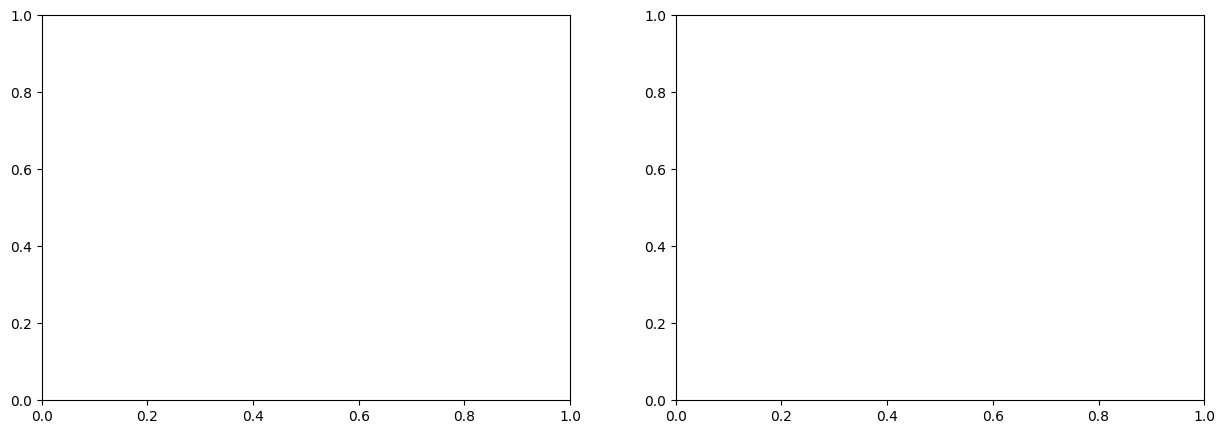

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Adjust figsize as needed
titles = [f'original acc. {original_acc}%', f'attacked acc. {attacked_acc}%']

for i, img in enumerate([X[0].permute(1,2,0).detach().cpu(),
                         X_attacked[0].permute(1,2,0).detach().cpu()]):
    
    axs[i].imshow(img)
    axs[i].axis('off')  # Turn off axis
    axs[i].set_title(titles[i])  # Set title for each subplot


&nbsp;

Now let's apply the diffpure technique to the attacked images. If the purification is sucessfull, the accuracy of the classifier should sharply increase. This means that the adversarial noise was not only removed, but the image preseves the right semantic to be recognizable by the classifier.

After using the diffpure architecture the classifier accuracy is increased from 0% to 77.34%.


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Create a dataloader from the attacked images
attacked_data = TensorDataset(X_attacked, Y_attacked)
attacked_loader = DataLoader(attacked_data, batch_size=1)  # set the batch size according to your hardware capacities

# Wrap the models and dataloaders using the accelerator class so it takes care of the GPU managment
#purifier, attacked_loader, classifier = accelerator.prepare(purifier, attacked_loader, classifier)


In [ ]:
# Purify the images iterating on the batch loader
purified_images = []
i = 0
for batch in tqdm(attacked_loader):
    if i< 1:
        inputs, targets = batch
        outputs = purifier.transform(inputs)
        purified_images.append(outputs)
        i += 1
# Stack the purified images in a single object.
purified_images = torch.vstack(purified_images)

# Calculate the acurracy of the purified images
purified_acc = attack.clean_accuracy(purified_images, Y)*100
print(f'Accuracy after purification {purified_acc}%')


&nbsp;

Upon visual inspection, it is observed that the purified image appears less sharp than the original. This is potentially due to the purification process introducing noisy artifacts altering the real texture of the welding and the material. However, despite these details, the overall semantic integrity of the image, including the size of the weld and its contact points, is preserved. The accuracies reported are calculated on the whole 128 test image batch.



In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = [f'original. Acc {original_acc}%', f'purified. Acc {purified_acc}%', f'attacked. Acc {attacked_acc}%']

for i, img in enumerate([X[0].permute(1,2,0).detach().cpu(),
                         purified_images[0].permute(1,2,0).detach().cpu(),
                         X_attacked[0].permute(1,2,0).detach().cpu()]):
    
    axs[i].imshow(img)
    axs[i].axis('off') 
    axs[i].set_title(titles[i])


In [ ]:
# Model's predictions on the original data
original_outputs = classifier(X)
original_outputs.argmax(1)


In [ ]:
# Model's predictions on the attacked data
attacked_outputs = classifier(X_attacked)
attacked_outputs.argmax(1)


In [ ]:
# Y true labels
Y


In [ ]:
# Model's predictions on the purified data
classifier = classifier.eval()
purified_outputs = classifier(purified_images)
purified_outputs.argmax(1)

In [ ]:
end=time.time()
print("temps final : ",end-start)